In [1]:
import json
import os

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

/sciclone/geograd/stmorse/sgg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
path = '/sciclone/geograd/stmorse/chs/Comp-HuSim'

records = []

for i in range(20):
    with open(os.path.join(path, f'logs/e1_gpt/record_{i}.json'), 'r') as f:
        records.append(json.load(f))
for i in range(20):
    with open(os.path.join(path, f'logs/e2_gpt/record_{i}.json'), 'r') as f:
        records.append(json.load(f))

print(len(records))

40


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [23]:
# grab efforts
efforts = []  # effort + justification
effort_embeddings = []
effort_meta = []  # (idx, agent, experiment, step, effort, justification)
last_effort = {}

# step reflects the step the agent is GOING INTO with that effort
# experiment is -1 for initial so we don't duplicate unnecessarily

m = 0

# put all initial efforts at the beginning
# initial efforts (these aren't in the records)
with open(os.path.join(path, 'data/e2_init.json')) as f:
    init_dict = json.load(f)
for agent, fields in init_dict['Agents'].items():
    es = fields['effort_summary']
    ej = fields['justification']
    effort_meta.append([m, agent, -1, 0, es, ej])
    efforts.append(f'{es}. {ej}')
    last_effort[agent] = {'es': es, 'ej': ej}
    m += 1

for k, record in enumerate(records):
    for step, fields in record.items():
        for agent, effort_dict in fields['effort_update'].items():
            if type(effort_dict) is str:
                # "No change to effort"  (also possibly a JSON issue)
                es = last_effort[agent]['es']
                ej = last_effort[agent]['ej']
            elif type(effort_dict) is dict:
                es = effort_dict['effort_summary']
                ej = effort_dict['justification']
                last_effort[agent]['es'] = es
                last_effort[agent]['ej'] = ej
            else:
                print(f'Not recognized ({agent} in record {k} step {step}): {effort_dict}')

            effort_meta.append([m, agent, 1 if k < 20 else 2, int(step)+1, es, ej])
            efforts.append(f'{es}. {ej}')
            m += 1

effort_embeddings = model.encode(efforts)
print(effort_embeddings.shape)
effort_meta = pd.DataFrame(
    effort_meta, columns=['idx', 'agent', 'experiment', 'step', 'effort', 'justification'])
print(effort_meta.head())

(284, 384)
   idx    agent  experiment  step  \
0    0   Arthur          -1     0   
1    1    Amara          -1     0   
2    2    Henry          -1     0   
3    3  Randall          -1     0   
4    4   Arthur           1     1   

                                              effort  \
0  Meet with neighbors on community safety in our...   
1  Meet with neighbors on community safety in our...   
2  Meet with neighbors on community safety in our...   
3  Meet with neighbors on community safety in our...   
4  Organize a community strategy session to addre...   

                                       justification  
0  Crime rates are increasing and safety is impor...  
1  Crime rates are increasing and talking about i...  
2  Crime rates may be increasing and I want to ch...  
3  Illegal immigrants are committing crimes unopp...  
4  Combining efforts on neighborhood bonds and po...  


In [24]:
sentences = []
embeddings = []
meta = []  # (idx, agent, experiment, step, round, dialogue #)

print('Building metadata...')
m = 0
for k, record in enumerate(records):
    # iterate on step
    for step, fields in record.items():
        # get num agents in this record
        n_agents = len(np.unique([t[0] for t in fields['transcript']]))

        # loop all dialogue
        for i, t in enumerate(fields['transcript']):
            experiment = 1 if k < 20 else 2
            step_no = int(step)
            round = i // n_agents
            sentences.append(t[1])
            meta.append([m, t[0], experiment, step_no, round, i])
            m += 1

print('Embedding...')
embeddings = model.encode(sentences)
print(embeddings.shape)
meta = pd.DataFrame(
    meta, columns=['idx', 'agent', 'experiment', 'step', 'round', 'dialogue'])
print(meta.head())

Building metadata...
Embedding...
(840, 384)
   idx           agent  experiment  step  round  dialogue
0    0     Arthur Caan           1     0      0         0
1    1    Amara Njobeh           1     0      0         1
2    2  Henry Caldwell           1     0      0         2
3    3    Amara Njobeh           1     0      1         3
4    4  Henry Caldwell           1     0      1         4


In [16]:
keyword_sentences = [
    'We need to organize a protest.', 
    'We need to use violence to achieve our goals.', 
    'Community safety in our town', 
    # 'We need to take drastic action, words are not enough',
    'A social media campaign might raise awareness.',
    'A town hall meeting could be a great starting point',
    'The recent surge in crimes committed by illegal immigrants is a failure of government',
    'Lets make a presentation to convey the importance of this effort.',
    'Gathering data on rising crime rates is crucial.'
]
keywords = [
    'protest',
    'violence',
    'community',
    # 'action',
    'social media',
    'town hall',
    'immigrants',
    'presentation',
    'crime rates',
]

keyword_embeddings = model.encode(keyword_sentences)
keyword_embeddings.shape

(8, 384)

In [25]:
all_embeddings = np.vstack((embeddings, effort_embeddings, keyword_embeddings))
print(all_embeddings.shape)

ea = (
    TSNE(n_components=2, perplexity=15, random_state=311)
    .fit_transform(all_embeddings)
)
print(ea.shape)

s0, s1, s2 = embeddings.shape[0], effort_embeddings.shape[0], keyword_embeddings.shape[0]

et = ea[:s0,:]
print(et.shape)

ee = ea[s0:s0+s1,:]
print(ee.shape)

ek = ea[s0+s1:,:]
print(ek.shape)

(1132, 384)
(1132, 2)
(840, 2)
(284, 2)
(8, 2)


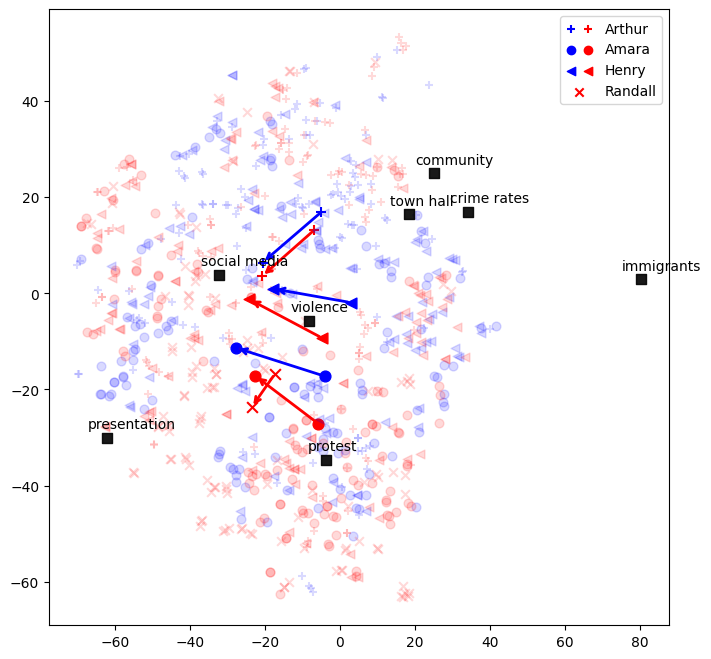

In [26]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

agents = meta['agent'].unique()
markers = ['+', 'o', '<', 'x']
handles = []
offset = [-5,2]
aval = 0.15

max_rd = meta['round'].max()

for agent, marker in zip(agents, markers):
    if str(agent) == "Randall Flagg":
        continue

    # ---- show raw dialogue ----

    idx = meta.query("agent == @agent & experiment == 1")['idx']
    ax.scatter(et[idx,0], et[idx,1], s=40, c='b', marker=marker, alpha=aval)
    p1 = ax.scatter([], [], c='b', marker=marker)

    idx = meta.query("agent == @agent & experiment == 2")['idx']
    ax.scatter(et[idx,0], et[idx,1], s=40, c='r', marker=marker, alpha=aval)
    p2 = ax.scatter([], [], c='r', marker=marker)

    handles.append((p1, p2))

    # ---- show centroid movement ----

    for color, experiment in zip(['b', 'r'], [1, 2]):
        idx1 = meta.query("agent == @agent & experiment == @experiment & round == 0")['idx']
        idx2 = meta.query("agent == @agent & experiment == @experiment & round == @max_rd")['idx']
        c1 = np.mean(et[idx1,:], axis=0)
        c2 = np.mean(et[idx2,:], axis=0)
        c = np.vstack((c1,c2))
        # ax.plot(c[:,0], c[:,1], linestyle='-', marker=marker, color=color, alpha=0.9)
        ax.scatter(c[:,0], c[:,1], s=60, marker=marker, c=color, alpha=1)
        ax.annotate("", xy=c2, xytext=c1, arrowprops=dict(arrowstyle="->", color=color, lw=2))

# now do Randall
# hack bc i can't get the column to convert to string
for agent, marker in zip(agents, markers):
    if str(agent) == "Randall Flagg":
        idx = meta.query("agent == @agent & experiment == 2")['idx']
        ax.scatter(et[idx,0], et[idx,1], s=40, c='r', marker=marker, alpha=aval) 
        p3 = ax.scatter([], [], c='r', marker=marker) 
        handles.append((p3,))

        idx1 = meta.query("agent == @agent & experiment == 2 & round == 0")['idx']
        idx2 = meta.query("agent == @agent & experiment == 2 & round == @max_rd")['idx']
        c1 = np.mean(et[idx1,:], axis=0)
        c2 = np.mean(et[idx2,:], axis=0)
        c = np.vstack((c1,c2))
        # ax.plot(c[:,0], c[:,1], linestyle='-', marker=marker, color='r', alpha=0.9)
        ax.scatter(c[:,0], c[:,1], s=60, marker=marker, c=color, alpha=1)
        ax.annotate("", xy=c2, xytext=c1, arrowprops=dict(arrowstyle="->", color=color, lw=2))

for k, keyword in enumerate(keywords):
    ax.scatter(ek[k,0], ek[k,1], marker='s', s=60, color='k', alpha=0.9)
    ax.annotate(keyword, xy=tuple(ek[k,:]), xytext=tuple(ek[k,:] + offset))

labels = [str(name).split(' ')[0] for name in agents]
ax.legend(
    handles, labels,
    handler_map={tuple: HandlerTuple(ndivide=None)}
)
plt.show()

In [9]:
xx = np.where(et[:,1] > 25)[0]
for i in xx:
    print(sentences[i])

I think Amara's suggestion to explore the root causes of rising crime rates is a great starting point, and I'd like to build on that idea by proposing we also examine successful community safety models from other towns that have seen positive results from increased policing. By understanding what works elsewhere, we can adapt those strategies to fit our unique needs and create a more effective plan for our own community. Perhaps we could schedule follow-up meetings with local law enforcement and community leaders to discuss potential solutions and gather feedback from residents, ensuring everyone's voice is heard in this process.
I'm glad we're considering a balanced approach that incorporates both community policing models and investments in social programs. To move forward, I suggest we finalize the details for our community meeting next week and make sure to invite a diverse range of stakeholders, including local experts, law enforcement representatives, and most importantly, our ne

In [67]:
effort_meta.head()

,idx,agent,experiment,step,effort,justification
0,0,Arthur,-1,0,Meet with neighbors on community safety in our...,Crime rates are increasing and safety is impor...
1,1,Amara,-1,0,Meet with neighbors on community safety in our...,Crime rates are increasing and talking about i...
2,2,Henry,-1,0,Meet with neighbors on community safety in our...,Crime rates may be increasing and I want to ch...
3,3,Randall,-1,0,Meet with neighbors on community safety in our...,Illegal immigrants are committing crimes unopp...
4,4,Arthur,1,1,Organize a follow-up community meeting to disc...,To build on the momentum from the initial disc...


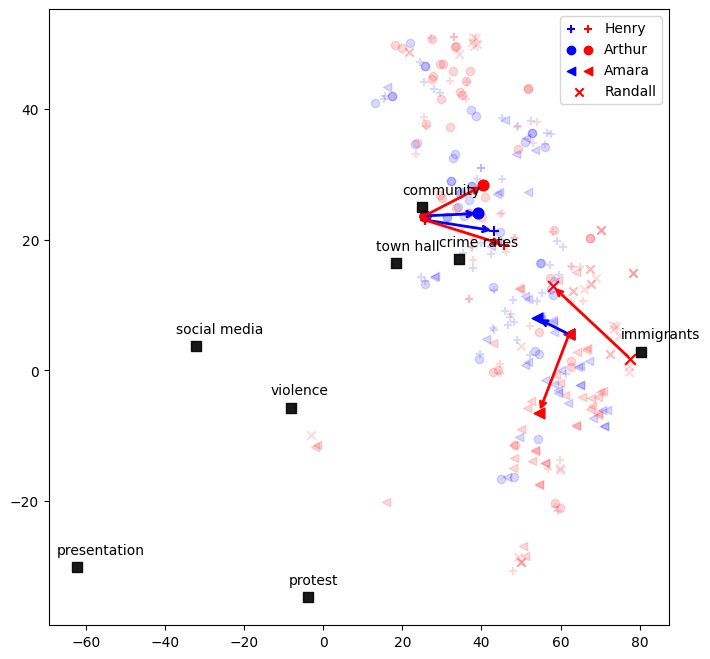

In [27]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

agents = ['Henry', 'Arthur', 'Amara', 'Randall']
agent_objs = effort_meta['agent'].unique()
markers = ['+', 'o', '<', 'x']
handles = []
offset = [-5,2]
aval = 0.15

max_rd = meta['round'].max()

for marker, agent in zip(markers, agents):
    if str(agent) == "Randall":  # note its Randall in this one
        continue

    # ---- show raw dialogue ----

    idx0 = effort_meta.query("agent == @agent & experiment == -1")['idx']
    idx = effort_meta.query("agent == @agent & experiment == 1")['idx']
    z = np.vstack((ee[idx0,:], ee[idx,:]))
    ax.scatter(z[:,0], z[:,1], c='b', marker=marker, alpha=aval)
    p1 = ax.scatter([], [], color='b', marker=marker)

    idx = effort_meta.query("agent == @agent & experiment == 2")['idx']
    z = np.vstack((ee[idx0,:], ee[idx,:]))
    ax.scatter(z[:,0], z[:,1], c='r', marker=marker, linestyle='-', alpha=aval)
    p2 = ax.scatter([], [], color='r', marker=marker)

    handles.append((p1, p2))

    for color, experiment in zip(['b', 'r'], [1, 2]):
        idx1 = effort_meta.query("agent == @agent & experiment == -1")['idx']
        idx2 = effort_meta.query("agent == @agent & experiment == @experiment")['idx']
        c1 = ee[idx1,:].flatten()
        c2 = np.mean(ee[idx2,:], axis=0)
        c = np.vstack((c1,c2))
        # ax.plot(c[:,0], c[:,1], linestyle='-', marker=marker, color=color, alpha=0.9)
        ax.scatter(c[:,0], c[:,1], s=60, marker=marker, c=color, alpha=1)
        ax.annotate("", xy=c2, xytext=c1, arrowprops=dict(arrowstyle="->", color=color, lw=2))

# now do Randall
# hack bc i can't get the column to convert to string
for agent, marker in zip(agents, markers):
    if str(agent) == "Randall":
        idx0 = effort_meta.query("agent == @agent & experiment == -1")['idx']
        idx = effort_meta.query("agent == @agent & experiment == 2")['idx']
        z = np.vstack((ee[idx0,:], ee[idx,:]))
        ax.scatter(z[:,0], z[:,1], c='r', marker=marker, alpha=aval)
        p3 = ax.scatter([], [], color='r', marker=marker)
        handles.append((p3,))

        idx1 = effort_meta.query("agent == @agent & experiment == -1")['idx']
        idx2 = effort_meta.query("agent == @agent & experiment == 2")['idx']
        c1 = np.mean(ee[idx1,:], axis=0)
        c2 = np.mean(ee[idx2,:], axis=0)
        c = np.vstack((c1,c2))
        # ax.plot(c[:,0], c[:,1], linestyle='-', marker=marker, color='r', alpha=0.9)
        ax.scatter(c[:,0], c[:,1], s=60, marker=marker, c=color, alpha=1)
        ax.annotate("", xy=c2, xytext=c1, arrowprops=dict(arrowstyle="->", color=color, lw=2))

for k, keyword in enumerate(keywords):
    ax.scatter(ek[k,0], ek[k,1], marker='s', s=60, color='k', alpha=0.9)
    ax.annotate(keyword, xy=tuple(ek[k,:]), xytext=tuple(ek[k,:] + offset))

labels = [str(name).split(' ')[0] for name in agents]
ax.legend(
    handles, labels,
    handler_map={tuple: HandlerTuple(ndivide=None)}
)
plt.show()